In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from glob import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import shutil
import random

### the code below is to create train & test different directories - run it once!

In [6]:
# set random seed for reproducibility
random.seed(42)

# define paths for dataset and train/test splits
data_path = "FMD_DATASET"
train_path = "train"
test_path = "test"

# create directories for train and test data
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# loop over each class in the dataset
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # create directories for train and test data for this class
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # get list of subdirectories for this class
    subdirectories = os.listdir(class_path)

    # loop over each subdirectory in the class
    for subdirectory_name in subdirectories:
        subdirectory_path = os.path.join(class_path, subdirectory_name)

        # create directories for train and test data for this subdirectory
        train_subdirectory_path = os.path.join(train_class_path, subdirectory_name)
        test_subdirectory_path = os.path.join(test_class_path, subdirectory_name)
        os.makedirs(train_subdirectory_path, exist_ok=True)
        os.makedirs(test_subdirectory_path, exist_ok=True)

        # get list of image filenames for this subdirectory
        images = os.listdir(subdirectory_path)

        # shuffle the list of images
        random.shuffle(images)

        # split the list of images into train and test sets
        split_index = int(len(images) * 0.8)  # 80% train, 20% test
        train_images = images[:split_index]
        test_images = images[split_index:]

        # move the train and test images to their respective directories
        for image in train_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(train_subdirectory_path, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(test_subdirectory_path, image)
            shutil.copyfile(src, dst)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'FMD_DATASET'

### load data with ImageDataGenerator

In [7]:
#Scale the pixel values of the images from a range of [0, 255] to [0, 1].
#Use 80% of the images for training and 20% for validation
datagen_train = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)
datagen_test = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)

In [8]:
data_train = datagen_train.flow_from_directory(
    "train",
    target_size=(150, 150),
    batch_size=800,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

data_test = datagen_test.flow_from_directory(
    "test",
    target_size=(150, 150),
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 11628 images belonging to 3 classes.
Found 2908 images belonging to 3 classes.


The Data Structure
Incorect: MC= 2500 , mmc =2500
With_mask: com = 789 , simple = 4000
Without_mask: com= 747, simple= 4000

First we will use ImageDataGenerator a class in the Keras library for deep learning, which is used to preprocess image data. The flow_from_directory method is used to generate batches of image data from a directory containing subdirectories of images, with each subdirectory representing a class label. The method takes the path to the directory containing the images as an argument.

DATA DETAILS

In [9]:
counts = np.bincount(data_train.labels)
print("classes: ",data_train.class_indices,
      "\nimage shape: ", data_train.image_shape,
      "\n  * class 'incorrect_mask' (0): ", counts[0],
      "\n  * class 'with_mask' (1): ", counts[1],
      "\n  * class 'without_mask' (2): ", counts[2],)

classes:  {'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2} 
image shape:  (150, 150, 3) 
  * class 'incorrect_mask' (0):  4000 
  * class 'with_mask' (1):  3831 
  * class 'without_mask' (2):  3797


In [10]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(3, activation='softmax'))

In [11]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
history = model_cnn.fit(data_train, epochs=4)

Epoch 1/4


c:\users\pc\pycharmprojects\ex3_machinelearning\venv\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 365s 23s/step - loss: 0.8440 - accuracy: 0.5875

In [13]:
# Save the model
model_cnn.save('cnn_model.h5')

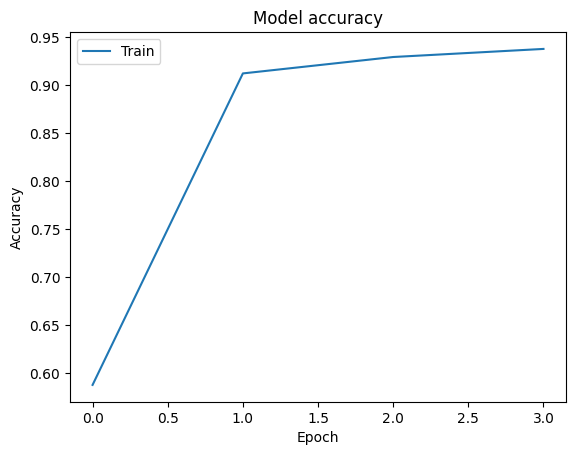

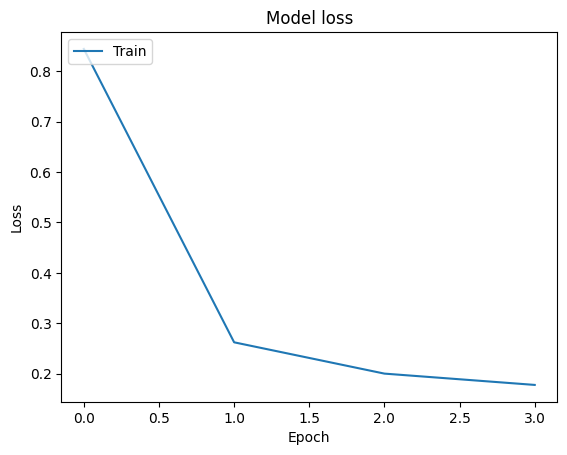

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [15]:
# Evaluate the model on the train data
train_loss, train_acc = model_cnn.evaluate(data_test)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)

# Evaluate the model on the test data
test_loss, test_acc = model_cnn.evaluate(data_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

91/91 [==============================] - 47s 508ms/step - loss: 0.2098 - accuracy: 0.9312